In [20]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats

In [21]:
# import huggingface_hub

# HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'

# huggingface_hub.login(HF_TOKEN)

import huggingface_hub

HF_TOKEN = ''

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/ji/.cache/huggingface/token
Login successful


### Model Setup

In [22]:
# Build model config
# opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = load_opt_from_config_files(["/media/Datacenter_storage/Ji/BiomedParse/configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = ':microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


### Utility Functions

In [23]:
def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):
        
        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(mask_temp, alpha=0.9)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
    
    plt.show()

In [24]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_rgb


def inference_rgb(file_path, text_prompts):
    image = read_rgb(file_path)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts)
    
    return image, pred_mask


### Pathology Example

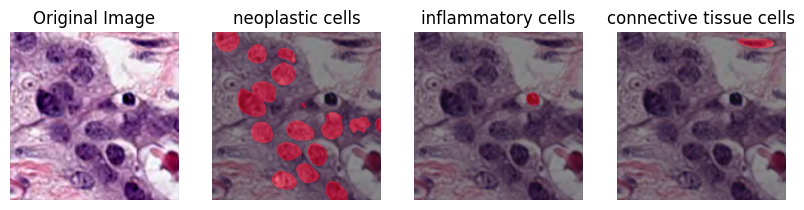

neoplastic cells P-value: 0.929195630848904
inflammatory cells P-value: 0.4377279527119923
connective tissue cells P-value: 0.5751546391124731


In [25]:
image_path = 'examples/CT_lung_nodule.dcm'
text_prompt = ['nodule']

image_path = 'examples/Part_1_516_pathology_breast.png'
text_prompt = ['neoplastic cells', 'inflammatory cells', 'connective tissue cells']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Pathology', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

#### Get Cell Instances

In [26]:
from inference_utils.processing_utils import get_instances

def plot_instance_segmentation_masks(original_image, segmentation_masks, text_prompt=None):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')
        
    instance_masks = [get_instances(1*(mask>0.5)) for mask in segmentation_masks]
    
    mask_names = [f'Mask {i+1}' for i in range(len(segmentation_masks))]
    if text_prompt:
        mask_names = text_prompt
        for i in range(len(mask_names)):
            mask_names[i] = mask_names[i].strip()


    for i, mask in enumerate(instance_masks):
        ins_ids = np.unique(mask)
        count = len(ins_ids[ins_ids > 0])
        
        ax[i+1].set_title(f'{mask_names[i]} ({count})')
        mask_temp = np.zeros_like(original_image)
        for ins_id in ins_ids:
            if ins_id == 0:
                continue
            mask_temp[mask == ins_id] = np.random.randint(0, 255, 3)
            if ins_id == 1:
                mask_temp[mask == ins_id] = [255, 0, 0]
        
        ax[i+1].imshow(mask_temp, alpha=1)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
        
    plt.show()

MaskImageFilter (0x7ffe863f7f00): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffe863f7f00): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffe863f7f00): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 

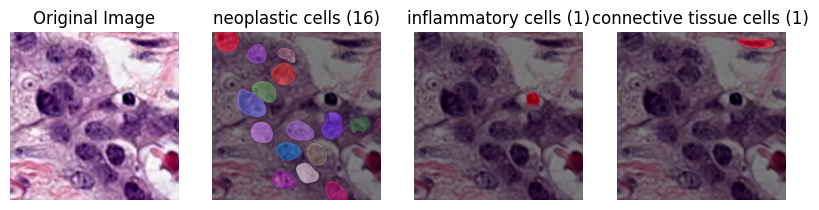

In [27]:
plot_instance_segmentation_masks(image, pred_mask, text_prompt)

### X-Ray Example

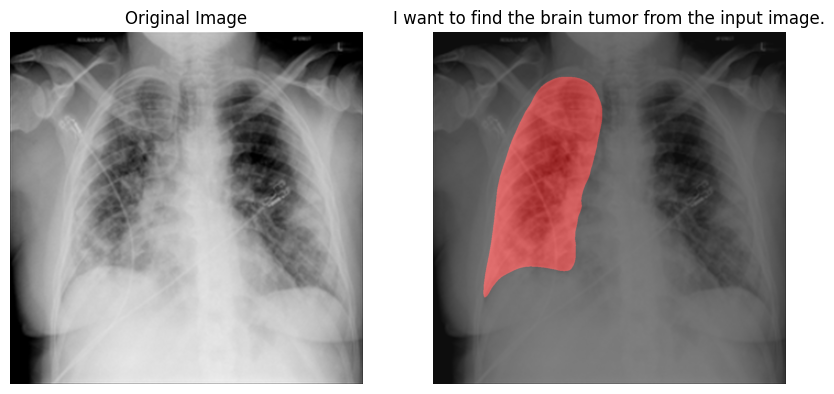

In [32]:
image_path = 'examples/covid_1585.png'
text_prompt = ['left lung', 'right lung', 'COVID-19 infection']
text_prompt = ['I want to find the brain tumor from the input image.']


image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)-1):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'X-Ray-Chest', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Fundus Example

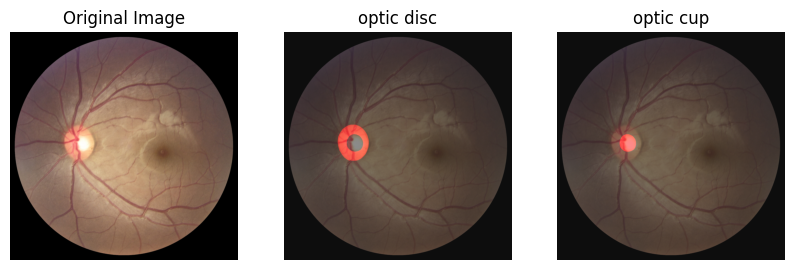

optic disc P-value: 0.6497410560504703
optic cup P-value: 0.5824655806125306


In [29]:
image_path = 'examples/T0011.jpg'
text_prompt = ['optic disc', 'optic cup']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Fundus', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Endoscope Example

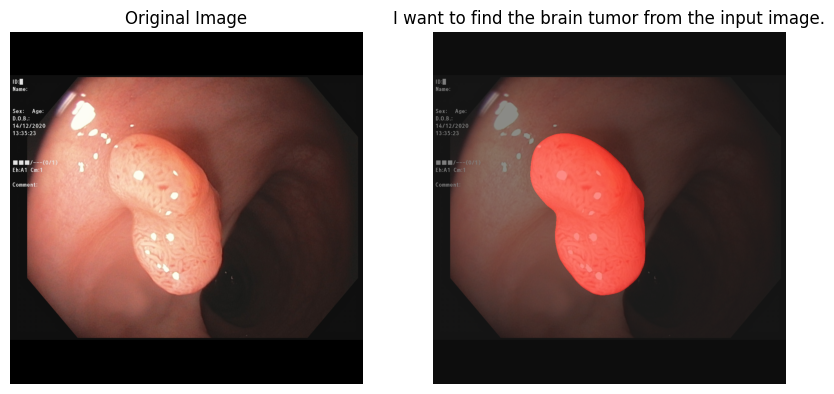

ValueError: Currently support targets for Endoscopy: ['neoplastic polyp', 'polyp', 'non-neoplastic polyp']

In [31]:
image_path = 'examples/C3_EndoCV2021_00462.jpg'
# text_prompt = ['polyp']
text_prompt = ['I want to find the brain tumor from the input image.']


image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Endoscopy', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Dermoscopy Example

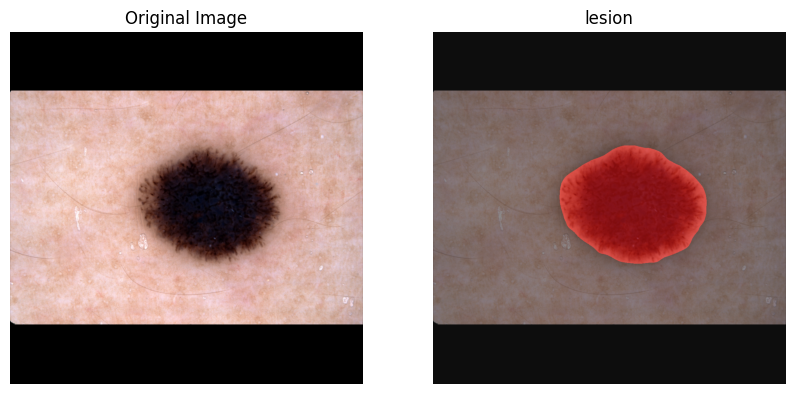

lesion P-value: 0.136371588270927


In [ ]:
image_path = 'examples/ISIC_0015551.jpg'
text_prompt = ['lesion']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Dermoscopy', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### OCT Example

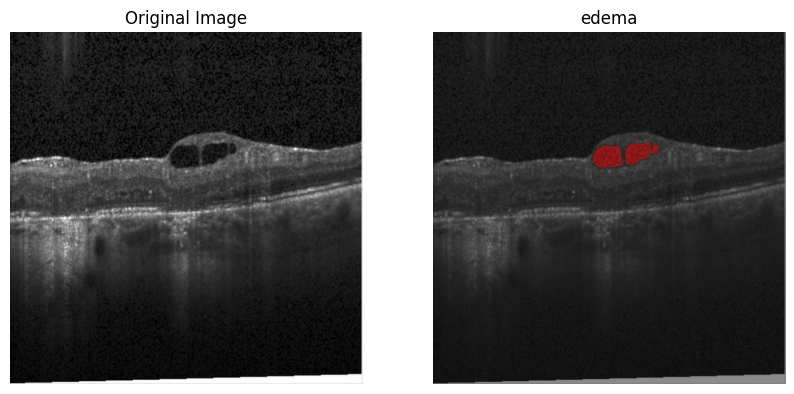

edema P-value: 0.33625537176351805


In [ ]:
image_path = 'examples/144DME_as_F.jpeg'
text_prompt = ['edema']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'OCT', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')